# Long Term Rating Perdiction

## Import of all the necessary packages

In [1]:
import sys
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install tabulate
!{sys.executable} -m pip install playsound

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Imputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
import statsmodels.api as sm
from statsmodels.imputation.mice import MICE, MICEData as mice
# import fancyimpute
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import time
from collections import Counter
from sklearn.utils import resample
from xgboost.sklearn import XGBClassifier
import seaborn as sn
from tabulate import tabulate
from playsound import playsound
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 14
np.random.seed(1)

## Importing and merging the data

### Ratios, Ratings, Company Codes

We gather the relevant data.

In [3]:
df1 = pd.read_csv('Data/SP500_CompanyList.csv')
df1.drop(['date'], 1, inplace=True)
df1.drop(['COMNAM'], 1, inplace=True)
df1.drop(['NWPERM'], 1, inplace=True)
df1.drop(['NCUSIP'], 1, inplace=True)
df1.drop(['PERMCO'], 1, inplace=True)
df1.drop(['PRC'], 1, inplace=True)
#print(df1.head())

df2 = pd.read_csv('Data/RatiosSP500.csv', parse_dates=['public_date'])
df2 = df2.rename(columns = {"permno":"PERMNO"})
df2.drop(['adate'], 1, inplace=True)
df2.drop(['qdate'], 1, inplace=True)
#print(df2.head())

df3 = df1.merge(right=df2, how='outer', on='PERMNO')
df3 = df3.rename(columns = {"TICKER":"tic"})
df3.drop(['PERMNO'], 1, inplace=True)
df3.drop(['CUSIP'], 1, inplace=True)
#print(df3.head(10))

df4 = pd.read_csv('Data/RatingsSP500_v2.csv', parse_dates=['datadate'])
df4.drop(['gvkey'], 1, inplace=True)
df4.drop(['conm'], 1, inplace=True)
df4.drop(['cusip'], 1, inplace=True)
df4.drop(['spsticrm'], 1, inplace=True)
df4.drop(['gind'], 1, inplace=True)
df4.drop(['ggroup'], 1, inplace=True)
df4.drop(['gsubind'], 1, inplace=True)
df4.drop(['naics'], 1, inplace=True)
df4.drop(['sic'], 1, inplace=True)
df4.drop(['spcindcd'], 1, inplace=True)
df4.drop(['spcseccd'], 1, inplace=True)
df4 = df4.rename(columns = {"datadate":"public_date"})
#print(df4.head())

df5 = pd.read_csv('Data/Prices_SP500.csv', parse_dates=['date'])
df5.drop(['NCUSIP'], 1, inplace=True)
df5.drop(['COMNAM'], 1, inplace=True)
df5.drop(['PERMNO'], 1, inplace=True)
df5.drop(['CUSIP'], 1, inplace=True)
df5.drop(['NWPERM'], 1, inplace=True)
df5.drop(['PERMCO'], 1, inplace=True)
df5 = df5.rename(columns = {"date":"public_date"})
df5 = df5.rename(columns = {"TICKER":"tic"})
df5['mm'] = pd.DatetimeIndex(df5['public_date']).month
df5['yyyy'] = pd.DatetimeIndex(df5['public_date']).year
#df5.head()

### Factorize gsector (get dummies)

The gsector feature needs to be factorized, to stop the model from assuming ordinality of the values!
To do so we use the get_dummies function from pandas. But we need to convert the group to strings fist.

In [4]:
df4['gsector'] = df4['gsector'].astype(str)
df4 = pd.get_dummies(df4, prefix=['gsector'], columns=['gsector'])
df4.head()

,splticrm,public_date,tic,gsector_10,gsector_15,gsector_20,gsector_25,gsector_30,gsector_35,gsector_40,gsector_45,gsector_50,gsector_55,gsector_60
0,B-,2010-01-31,AAL,0,0,1,0,0,0,0,0,0,0,0
1,B-,2010-02-28,AAL,0,0,1,0,0,0,0,0,0,0,0
2,B-,2010-03-31,AAL,0,0,1,0,0,0,0,0,0,0,0
3,B-,2010-04-30,AAL,0,0,1,0,0,0,0,0,0,0,0
4,B-,2010-05-31,AAL,0,0,1,0,0,0,0,0,0,0,0


The different files are now merged into one data dataframe

In [5]:
dfprov = df3.merge(right=df4, how='outer', on=['tic', 'public_date'])
dfprov['mm'] = pd.DatetimeIndex(dfprov['public_date']).month
dfprov['yyyy'] = pd.DatetimeIndex(dfprov['public_date']).year
dfprov.head(40)
df = dfprov.merge(right=df5, how='outer', on=['tic', 'yyyy','mm'])
df.head()

,tic,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,gsector_35,gsector_40,gsector_45,gsector_50,gsector_55,gsector_60,mm,yyyy,public_date_y,PRC
0,ORCL,2010-01-31,26.386,0.252,10.110,19.217,19.378,20.052,20.052,4.976,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2010.0,2010-01-29,23.0600
1,ORCL,2010-02-28,28.226,0.252,10.110,20.542,20.714,21.435,21.435,5.323,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2010.0,2010-02-26,24.6500
2,ORCL,2010-03-31,29.464,0.252,10.110,21.425,21.605,22.357,22.357,5.556,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2010.0,2010-03-31,25.7100
3,ORCL,2010-04-30,28.783,0.233,10.983,21.378,21.556,23.096,23.096,5.381,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2010.0,2010-04-30,25.8675
4,ORCL,2010-05-31,25.096,0.233,10.983,18.653,18.808,20.152,20.152,4.692,...,0.0,0.0,1.0,0.0,0.0,0.0,5.0,2010.0,2010-05-28,22.5700


### Bond rates and inflation

We add 1Y, 5Y and 10Y US-treasury bond rates as well as yearly US-Dollar inflation. Eventhough we do not expect to get particular factor importance, we want to illustrate a way to introduce country risk into our algorithms.

In [6]:
#We then add 1Y, 5Y and 10Y US-treasury bond rates as well as yearly US-Dollar inflation
rates1Y = pd.read_csv('Data/RATE_1Y.csv', parse_dates=['DATE'])
rates5Y = pd.read_csv('Data/RATE_5Y.csv', parse_dates=['DATE'])
rates10Y = pd.read_csv('Data/RATE_10Y.csv', parse_dates=['DATE'])
inflation= pd.read_csv('Data/inflation_YEARLY.csv', parse_dates=['DATE'])

dfprov2=rates1Y.merge(right=rates5Y, on="DATE")
dfprov2=dfprov2.merge(right=rates10Y, on="DATE")
dfprov2=dfprov2.merge(right=inflation, how="outer", on="DATE")
#print(dfprov2.head())

dfprov2 = dfprov2.rename(columns = {"DATE":"public_date_x"})
dfprov2 = dfprov2.rename(columns = {"DGS1":"1Y"})
dfprov2 = dfprov2.rename(columns = {"DGS5":"5Y"})
dfprov2 = dfprov2.rename(columns = {"DFII10":"10Y"})
dfprov2 = dfprov2.rename(columns = {"FPCPITOTLZGUSA":"inflation"})
#print(dfprov2.head(220))

dfprov2.inflation=dfprov2.inflation.fillna(method='ffill')
#print(dfprov2.head(220))

#replace '.' with NAs to be filled by the Imputer
dfprov2['1Y'][dfprov2['1Y']=='.']=np.nan
dfprov2['5Y'][dfprov2['5Y']=='.']=np.nan
dfprov2['10Y'][dfprov2['10Y']=='.']=np.nan
dfprov2['1Y'] = pd.to_numeric(dfprov2['1Y'])
dfprov2['5Y'] = pd.to_numeric(dfprov2['5Y'])
dfprov2['10Y'] = pd.to_numeric(dfprov2['10Y'])

df_test=df.merge(right=dfprov2, on="public_date_x")
#print(df_test.head())
df=df_test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Calculations and further formatting

### Add return on share price

As a last step, we add a new column called logret, the return on share price. This might gives us some insight on how marketvalues determine credit ratings.

In [7]:
df["logret"] = df.groupby('tic')['PRC'].apply(lambda x: np.log(x) - np.log(x.shift()))
df.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


,tic,public_date_x,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,gsector_60,mm,yyyy,public_date_y,PRC,1Y,5Y,10Y,inflation,logret
0,ORCL,2010-03-31,29.464,0.252,10.110,21.425,21.605,22.357,22.357,5.556,...,0.0,3.0,2010.0,2010-03-31,25.7100,0.41,2.55,1.6,1.640043,NaN
1,MSFT,2010-03-31,17.722,0.166,9.138,15.662,15.917,16.181,16.181,4.372,...,0.0,3.0,2010.0,2010-03-31,29.2875,0.41,2.55,1.6,1.640043,NaN
2,TROW,2010-03-31,27.901,0.209,17.858,32.335,33.114,33.315,33.315,7.618,...,0.0,3.0,2010.0,2010-03-31,54.9700,0.41,2.55,1.6,1.640043,NaN
3,HON,2010-03-31,15.673,0.313,7.793,14.650,14.746,15.884,15.884,1.120,...,0.0,3.0,2010.0,2010-03-31,45.2700,0.41,2.55,1.6,1.640043,NaN
4,ADM,2010-03-31,11.404,0.761,10.642,14.523,14.523,16.609,16.609,0.299,...,0.0,3.0,2010.0,2010-03-31,28.9000,0.41,2.55,1.6,1.640043,NaN
5,FISV,2010-03-31,17.753,0.486,8.613,16.481,16.588,16.697,16.588,1.900,...,0.0,3.0,2010.0,2010-03-31,50.7600,0.41,2.55,1.6,1.640043,NaN
6,CERN,2010-03-31,49.298,0.234,14.278,35.536,36.766,36.766,36.766,4.160,...,0.0,3.0,2010.0,2010-03-31,84.9300,0.41,2.55,1.6,1.640043,NaN
7,KO,2010-03-31,22.193,0.201,14.863,18.092,18.212,18.771,18.771,4.091,...,0.0,3.0,2010.0,2010-03-31,55.0000,0.41,2.55,1.6,1.640043,NaN
8,CDNS,2010-03-31,-5.948,0.067,-711.630,-13.340,-13.340,-11.500,-11.500,2.115,...,0.0,3.0,2010.0,2010-03-31,6.6700,0.41,2.55,1.6,1.640043,NaN
9,ED,2010-03-31,14.778,1.241,8.767,14.095,14.185,14.185,14.185,0.962,...,0.0,3.0,2010.0,2010-03-31,44.5400,0.41,2.55,1.6,1.640043,NaN


### Convert Percentage data into floats

For further calculations we convert all percentage numbers from 'DIVYIELD' to floats

In [8]:
df['DIVYIELD'] = (pd.to_numeric(df['DIVYIELD'].str[:-1]).div(100).mask(df['DIVYIELD'] == '%',0))

### Factorize long term ratings

We now want to check the values of the "splticrm" column (=ratings), (Y-column)

In [9]:
df['splticrm'].value_counts()

BBB     4593
BBB+    4051
A-      3169
A       2805
BBB-    2801
BB+     1474
A+      1464
BB       904
BB-      879
AA-      729
B+       348
AA       343
AAA      210
B        178
AA+      139
B-        99
CCC+      37
D         17
Name: splticrm, dtype: int64

After checking this, we see that there are only 3 observations that have rating "D". We further explore which rows these are and we decide to drop this values. In particular the observations that have rating "D", mostly consist of rows with almost all values missing,therefore we don't get any valid information from them.

In [10]:
df = df[df['splticrm'] != 'D']

In [11]:
df['splticrm'].value_counts() #the observations with "D" aren't in our dataset anymore

BBB     4593
BBB+    4051
A-      3169
A       2805
BBB-    2801
BB+     1474
A+      1464
BB       904
BB-      879
AA-      729
B+       348
AA       343
AAA      210
B        178
AA+      139
B-        99
CCC+      37
Name: splticrm, dtype: int64

Now we want to factorize this ratings
We decide to choose 5 different categories as follows:

AAA  till  AA- : 4

A+   till  A-  : 3

BBB+ till  BBB-: 2

BB+  till  BB- : 1

B+   till  CCC+: 0

In [12]:
mapping ={'AAA': 4,'AA+': 4, 'AA':4, 'AA-':4, 'A+': 3, 'A':3, 'A-': 3, 'BBB+':2, 'BBB':2, 'BBB-': 2, 'BB+':1, 'BB':1, 'BB-': 1, 'B+':0, 'B':0, 'B-': 0, 'CCC+': 0}

df.loc[:, 'splticrm'] = df.loc[:,'splticrm'].replace(mapping)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
df['splticrm'].value_counts()

2.0    11445
3.0     7438
1.0     3257
4.0     1421
0.0      662
Name: splticrm, dtype: int64

## Handling missing values

### Check missing values per column

Now we want to check how many missing values there are per column (percentage)

In [14]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
print(missing_value_df.head(100))
#as we now see, all the columns have at least 65% of nonmissing values, 
#therefore we decide not to drop any column at the moment
percent_missing2 = df[df == 0].count(axis=0)/len(df)
missing_value_df2 = pd.DataFrame({'percent_missing2': percent_missing2})
missing_value_df2.sort_values('percent_missing2', inplace=True, ascending=False)
print(missing_value_df2.head(100))

#Drop all columns with more than 45% zero-values, which arent dummies
df.drop(['staff_sale', 'rd_sale', 'adv_sale'], axis=1, inplace=True)

                 percent_missing
PEG_trailing           41.327703
sale_nwc               34.993243
DIVYIELD               33.827703
cash_conversion        29.317568
inv_turn               26.118243
invt_act               23.692568
pretret_earnat         23.128378
pretret_noa            23.128378
rect_act               23.054054
curr_debt              22.983108
ocf_lct                22.959459
cash_ratio             22.902027
quick_ratio            22.902027
profit_lct             22.902027
curr_ratio             22.902027
int_debt               21.172297
int_totdebt            20.560811
intcov_ratio           19.135135
intcov                 19.135135
splticrm               18.165541
PEG_ltgforward         17.300676
efftax                 16.689189
dpr                    15.773649
short_debt             14.922297
PEG_1yrforward         14.547297
sale_equity            12.820946
dltt_be                12.804054
roe                    12.760135
bm                     12.679054
ptb       

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Check for missing values per row

We want to drop all rows where the missing values are more than 70% the dummies columns don't count, so its 94-11=83 this is 83*0.7 = 58 missing values therefore we specify the threshold as at least 83-56 = 27

In [15]:
df.dropna(axis=0, thresh=27, inplace=True)
# df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We  create an ID column, allowing us to merge the imputed dataset with the non-numerical dataset.

In [16]:
df['ID']=df.index

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Statsmodels MICE

MICE procedure with 5 repetitions (Predictive mean matching) is applied to impute our dataset. To refrain from distortions such as multicolinearity we drop irrelevant and troubling variables such as date variables.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\imputation\mice.py:1081: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ix = dxi[[jj, ir]]
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\imputation\mice.py:1082: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  iz = ixm[[jj, ix]]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

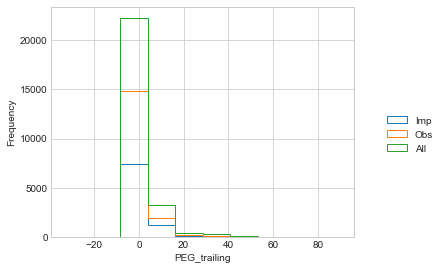

In [17]:
df_imp = df.drop(['tic', 'public_date_x', 'mm', 'yyyy', 'public_date_y', '1Y', '5Y', '10Y', 'splticrm'], axis=1)
imp = mice(df_imp)
imp.update_all(5)
imp.plot_imputed_hist('PEG_trailing')
imp.data.to_csv('Data/MICEImputedData.csv')
df_imp = pd.read_csv('Data/MICEImputedData.csv')

In [18]:
print(df_imp.isna().sum().sum())

0


### SimpleImputer (not in use since MICE works)

If for some unlikely reasons MICE does not work we provide a second option in the following:

In [19]:
#df_imp = df.drop(['tic', 'public_date_x', 'mm', 'yyyy', 'inflation', '1Y', '5Y', '10Y', 'public_date_y', 'splticrm'], axis=1)

#imp = SimpleImputer(missing_values=np.nan, strategy = 'mean')
#imputed_data = imp.fit_transform(df_imp.values)
#df_imp = pd.DataFrame(imputed_data, columns=df_imp.columns)
#print(df_imp.isnull().sum().sum())
#print(df_imp.isna().sum().sum())

### Merge Data again for complete dataset: Basesheet

We put the imputed data back together with the not imputed data and check for remaining missing values. 

In [20]:
df2 = df[['ID','tic', 'public_date_x', 'mm', 'yyyy', 'inflation', '1Y', '5Y', '10Y', 'splticrm']]
df3 = df2.merge(right=df_imp, how='outer',on='ID')
print(df3.isnull().sum().sum())
print(df3.isna().sum().sum())

6233
6233


In [21]:
df3.drop(['ID'], 1, inplace=True)
df=df3

As the values of our bond rates are rather stable we fill the missing interest rates via ffill

In [22]:
#print(df['1Y'].isnull().sum())
#print(df['5Y'].isnull().sum())
#print(df['10Y'].isnull().sum())
df.sort_values(by=['public_date_x'])
df['1Y'].fillna(method='ffill', inplace=True)
df['5Y'].fillna(method='ffill', inplace=True)
df['10Y'].fillna(method='ffill', inplace=True)
print(df.isnull().sum().sum())
print(df[['1Y','5Y','10Y']].isnull().sum().sum())

4946
0


To fill the missing response values, we use the median of the rating, grouped by firm (ticker).
This allows us to get the average rating of a firm, without the influence from outliers.
In doing so, we can fill about 1500 of the missing ratings.

In [23]:
df_prov3=df
print(df_prov3['splticrm'].isnull().sum())
print(df_prov3['splticrm'].value_counts())
df_prov3['splticrm'] = df.groupby(['tic'], sort=False)['splticrm'].apply(lambda x: x.fillna(x.median()))
#print(df_prov3['splticrm'].value_counts())
df_prov3.round({'splticrm': 0})
print(df_prov3['splticrm'].value_counts())
print(df_prov3['splticrm'].isnull().sum())
df=df_prov3

4946
2.0    9868
3.0    6897
1.0    2796
4.0    1394
0.0     603
Name: splticrm, dtype: int64
2.0    10611
3.0     6984
1.0     3269
4.0     1435
0.0      757
Name: splticrm, dtype: int64
3448


We decide to drop all remaining NaNs in the rating column, because there are few firms that have several missing ratings.

In [ ]:
print(df.groupby(['tic'], sort=False)['splticrm'].apply(lambda x: x.isna().sum()))
df=df.dropna(subset=['splticrm'])
print(df.isnull().sum().sum())

tic
ORCL     0
MSFT     0
TROW    60
HON      0
ADM      0
FISV     0
CERN    60
KO       0
CDNS     0
ED       0
CELG     0
XRAY     0
FAST    60
DTE      0
ETN      0
SIVB     0
XOM      0
MGM      0
MXIM     0
WM       0
GD       0
GE       0
LH       0
PBCT     0
IBM      0
ITT      0
KSU      0
PCG      0
PEP      0
MO       0
        ..
FRC      0
FLT      0
KMI      0
HCA      0
HII      0
MPC      0
FBHS     0
XYL      0
TRIP    42
PSX      0
FB      39
FANG     0
ABBV     0
ZTS      0
IQV      0
NWSA    29
COTY     0
TWTR     0
HLT      0
ANET    20
SYF      0
CFG      0
KEYS     0
MLSS    13
KHC      0
PYPL     0
WMIH    11
HPE      0
FTV      0
LW       0
Name: splticrm, Length: 457, dtype: int64
0


We now save it as dataframe inside the working directory for further use

In [ ]:
df.to_csv("Data/Basesheet.csv")

If you only want to run the algorithms then you can start from here on

In [30]:
df = pd.read_csv('Data/Basesheet.csv')

# Machine learning algorithms in action

### Preparing Basesheet: Feature, Response split

We define X by dropping columns not used by machine learning algorithms and also the ratings (b.c. it's the Y)

In [31]:
X = df.drop(['tic', 'splticrm','public_date_x', 'mm', 'yyyy','Unnamed: 0', 'Unnamed: 0.1'],1)
#define Y
y = df['splticrm']

print(X.isnull().sum().sum())
print(y.isnull().sum().sum())

0
0


### Resampling with SMOTE: Synthetic Minority Over-sampling Technique

In [32]:
print('BEFORE over sampling dataset shape %s' % Counter(y))
sm = SMOTE(random_state=1, sampling_strategy='all', k_neighbors=10, n_jobs=-1)
X, y = sm.fit_resample(X,y)
print('AFTER over sampling dataset shape %s' % Counter(y))

BEFORE over sampling dataset shape Counter({2.0: 10611, 3.0: 6984, 1.0: 3269, 4.0: 1435, 0.0: 757})
AFTER over sampling dataset shape Counter({3.0: 10611, 4.0: 10611, 2.0: 10611, 0.0: 10611, 1.0: 10611})


#### Resampling alternative with Resample() (not used since SMOTE works)

We provide another resampling code in the unlikely case that SMOTE does not work

In [33]:
# #Up- and Downsampling with the sklearn.resampler
# number_observations_per_class=5000

# df_u0=resample(df[df['splticrm']==0.0], replace=True, n_samples=number_observations_per_class, random_state=20)
# df_u1=resample(df[df['splticrm']==1.0], replace=True, n_samples=number_observations_per_class, random_state=21)
# df_u2=resample(df[df['splticrm']==2.0], replace=True, n_samples=number_observations_per_class, random_state=22)
# df_u3=resample(df[df['splticrm']==3.0], replace=True, n_samples=number_observations_per_class, random_state=23)
# df_u4=resample(df[df['splticrm']==4.0], replace=True, n_samples=number_observations_per_class, random_state=24)
# df = pd.concat([df_u0, df_u1, df_u2, df_u3, df_u4])
# #print(df_u0)
# print(df['splticrm'].value_counts())
# print(df['splticrm'].isnull().sum())

#### Train Test Split

Train test split according lecture.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)

## Extreme Gradient Boosting Algorithm 

In [9]:
start_time = time.time()

pipe_xgb = Pipeline([('scaler', StandardScaler()),
                     ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=2), threshold=0.01)),
                     ('classifier', XGBClassifier(n_jobs=-1, seed=1, eval_metric='merror', reg_alpha=0.01,
                                                  learning_rate=0.1, scale_pos_weight=0, max_depth=6, colsample_bytree=0.8,
                                                  gamma=0, n_estimators=2000, min_child_weight=0, sumsample=0.8))])

param_grid = {}

kFold = StratifiedKFold(n_splits=5, random_state=101)

grid = GridSearchCV(pipe_xgb, param_grid, cv=kFold, n_jobs=-1, verbose=10, refit=True)
grid.fit(X_train, y_train)

print('Best CV Training score: {:.4f}%'.format(grid.best_score_ * 100))
print('Best parameters: {}'.format(grid.best_params_), '\n')
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 24.9min remaining: 37.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 25.0min remaining: 16.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.6min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Best CV Training score: 99.3851%
Best parameters: {} 

--- 1920.4096353054047 seconds ---


In [10]:
print('Test score: {:.4f}%'.format(grid.score(X_test, y_test)*100), '\n')

Test score: 99.6796% 



#### Hyperparameter Tuning XGBoost:

'classifier__learning_rate': [0.1],
'classifier__n_estimators': [500, 1000, 2000, 5000],
'classifier__max_depth': [5, 6, 7],
'classifier__min_child_weight': [0, 1, 2],
'classifier__gamma': [0.0, 0.1, 0.2, 0.3, 0.4]
'classifier__subsample': [0.6, 0.7, 0.8, 0.9],
'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
'classifier__reg_alpha': [0.001, 0.01, 0.1, 1]

**Best hyperparameters:**
n_estimator = 2000, max_depth= 6, min_child_weight = 0, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, reg_alpha = 0.01

In [11]:
y_pred = grid.best_estimator_.predict(X_test)

In [12]:
confm = confusion_matrix(y_test , y_pred)
                         
FP = confm.sum(axis=0) - np.diag(confm)  
FN = confm.sum(axis=1) - np.diag(confm)
TP = np.diag(confm)
TN = confm.sum() - (FP + FN + TP)

# Metrics
Score = (TP+TN)/(TP+FP+FN+TN)
Errorrate = (FP+FN)/(TP+FP+FN+TN)
Specifity = TN/(TN+FP)
Sensivity = TP/(TP+FN)
Precision = TP/(TP+FP)
F1 = ((1+1**2)*TP)/((1+1**2)*TP+FN+FP)

Score = np.around(Score, decimals=4)
Errorrate = np.around(Errorrate, decimals=4)
Specifity = np.around(Specifity, decimals=4)
Sensivity = np.around(Sensivity, decimals=4)
Precision = np.around(Precision, decimals=4)
F1 = np.around(F1, decimals=4)

header = ('0.0','1.0','2.0','3.0','4.0')
Table=[header, Score,Errorrate,Specifity,Sensivity,Precision, F1]
##################################################################

print(65*"#")
print(' ')
print('PERFORMANCE REPORT XGBOOST')
print(' ')
print(65*"#")
print(' ')
print(65*"-")
print("METRICS")
print(65*"-")
print('Overall Accuracy score:  {:.2f}%'.format(accuracy_score(y_test , y_pred)*100))
print('Overall Error rate:      {:.2f}%'.format((1-accuracy_score(y_test , y_pred))*100))
print(65*"-")  
print(tabulate(Table, showindex=(['Rating Class','Score','Error-rate','Specifit','Sensivity','Precision','F1 (beta=1)']))) 
print(65*"-")
print("CONFUSION MATRIX")
print(65*"-")
print(confusion_matrix(y_test , y_pred))
print(65*"-")
print("CLASSIFICATION REPORT")
print(65*"-")
print(classification_report(y_test, y_pred))
print(65*"#")

#################################################################
 
PERFORMANCE REPORT XGBOOST
 
#################################################################
 
-----------------------------------------------------------------
METRICS
-----------------------------------------------------------------
Overall Accuracy score:  99.68%
Overall Error rate:      0.32%
-----------------------------------------------------------------
------------  ------  ------  ------  ------  ------
Rating Class  0       1       2       3       4
Score         0.9996  0.9992  0.998   0.9975  0.9992
Error-rate    0.0004  0.0008  0.002   0.0025  0.0008
Specifit      0.9998  0.9996  0.9992  0.9979  0.9995
Sensivity     0.9991  0.9976  0.9935  0.9962  0.9977
Precision     0.9991  0.9986  0.9967  0.9914  0.9981
F1 (beta=1)   0.9991  0.9981  0.9951  0.9938  0.9979
------------  ------  ------  ------  ------  ------
-----------------------------------------------------------------
CONFUSION MATRIX
-----------

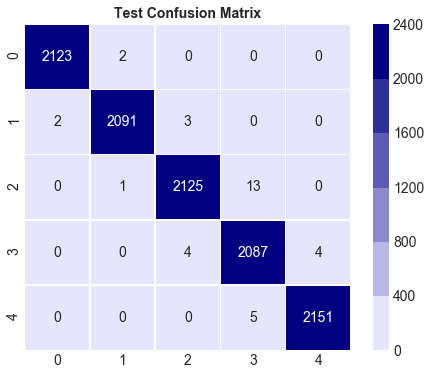

In [13]:
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = [i for i in "01234"], columns = [i for i in "01234"])
plt.figure(figsize= (8,6))
plt.title('Test Confusion Matrix', fontsize=14, weight='bold')
sn.heatmap(df_cm, annot=True, vmin=0, vmax=2400, fmt="d", linewidths=0.4, cmap=sn.light_palette("navy"), square=True)
plt.savefig('Plots/ConfusionMatrixXGBoost.png')

## Random Forest Algorithm

In [61]:
start_time = time.time()

pipe_rf = Pipeline([('scaler', StandardScaler()), 
                    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=3), threshold=0.01)),
                    ('pca', PCA(random_state=4)),
                    ('classifier', RandomForestClassifier(n_jobs=-1, random_state=5, max_features = 0.2, max_depth=20, 
                                                          criterion = 'entropy', min_samples_leaf = 1, n_estimators=750))])

param_grid = {'pca__n_components': [1, 5, 10, 15, 25, 35]}

kFold = StratifiedKFold(n_splits=5, random_state=6)

grid = GridSearchCV(pipe_rf, param_grid, cv=kFold, n_jobs=-1, verbose=10)
grid.fit(X_train, y_train)

print('Best CV Training score: {:.4f}%'.format(grid.best_score_ * 100))
print('Best parameters: {}'.format(grid.best_params_), '\n')
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  2.4min remaining: 21.3min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  2.5min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  2.6min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  2.6min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  6.4min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  8.0min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  8.5min remaining:   56.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Best CV Training score: 98.2188%
Best parameters: {'pca__n_components': 35} 

--- 558.4198014736176 seconds ---


In [62]:
print('Test score: {:.4f}%'.format(grid.score(X_test, y_test)*100), '\n')

Test score: 98.6146% 



#### Hyperparameter Tuning Random Forest:

'classifier__max_features': [0.2, 'sqrt', 'log2'] <br>
'classifier__criterion': ['gini', 'entropy'] <br>
'classifier__n_estimators': [500, 750, 1000] <br>
'classifier__max_depth': [15, 20, 30] <br>
'classifier__min_samples_leaf': [1, 10, 50, 70] <br>

**Best hyperparameters** found by GridSearchCV: <br>
max_features = 0.2 criterion = 'entropy', n_estimators = 750, max_depth = 20, min_sample_leaf = 1

In [63]:
y_pred = grid.best_estimator_.predict(X_test)

In [64]:
confm = confusion_matrix(y_test , y_pred)
                         
FP = confm.sum(axis=0) - np.diag(confm)  
FN = confm.sum(axis=1) - np.diag(confm)
TP = np.diag(confm)
TN = confm.sum() - (FP + FN + TP)

# Metrics
Score = (TP+TN)/(TP+FP+FN+TN)
Errorrate = (FP+FN)/(TP+FP+FN+TN)
Specifity = TN/(TN+FP)
Sensivity = TP/(TP+FN)
Precision = TP/(TP+FP)
F1 = ((1+1**2)*TP)/((1+1**2)*TP+FN+FP)

Score = np.around(Score, decimals=4)
Errorrate = np.around(Errorrate, decimals=4)
Specifity = np.around(Specifity, decimals=4)
Sensivity = np.around(Sensivity, decimals=4)
Precision = np.around(Precision, decimals=4)
F1 = np.around(F1, decimals=4)

header = ('0.0','1.0','2.0','3.0','4.0')
Table=[header, Score,Errorrate,Specifity,Sensivity,Precision, F1]
##################################################################

print(65*"#")
print(' ')
print('PERFORMANCE REPORT RANDOM FOREST')
print(' ')
print(65*"#")
print(' ')
print(65*"-")
print("METRICS")
print(65*"-")
print('Overall Accuracy score:  {:.2f}%'.format(accuracy_score(y_test , y_pred)*100))
print('Overall Error rate:      {:.2f}%'.format((1-accuracy_score(y_test , y_pred))*100))
print(65*"-")  
print(tabulate(Table, showindex=(['Rating Class','Score','Error-rate','Specifit','Sensivity','Precision','F1 (beta=1)']))) 
print(65*"-")
print("CONFUSION MATRIX")
print(65*"-")
print(confusion_matrix(y_test , y_pred))
print(65*"-")
print("CLASSIFICATION REPORT")
print(65*"-")
print(classification_report(y_test, y_pred))
print(65*"#")

#################################################################
 
PERFORMANCE REPORT RANDOM FOREST
 
#################################################################
 
-----------------------------------------------------------------
METRICS
-----------------------------------------------------------------
Overall Accuracy score:  98.61%
Overall Error rate:      1.39%
-----------------------------------------------------------------
------------  ------  ------  ------  ------  ------
Rating Class  0       1       2       3       4
Score         0.9985  0.9941  0.9888  0.9926  0.9983
Error-rate    0.0015  0.0059  0.0112  0.0074  0.0017
Specifit      0.9993  0.9966  0.9933  0.9947  0.9988
Sensivity     0.9953  0.9838  0.971   0.9842  0.9963
Precision     0.9972  0.9861  0.9733  0.9786  0.9954
F1 (beta=1)   0.9962  0.985   0.9722  0.9814  0.9958
------------  ------  ------  ------  ------  ------
-----------------------------------------------------------------
CONFUSION MATRIX
-----

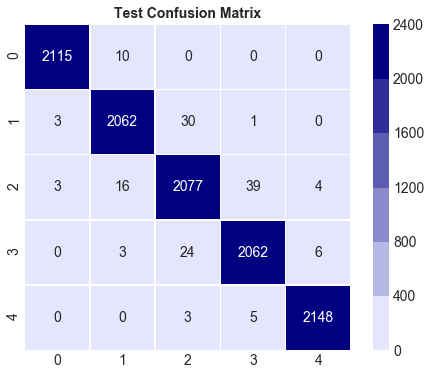

In [65]:
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = [i for i in "01234"], columns = [i for i in "01234"])
plt.figure(figsize= (8,6))
plt.title('Test Confusion Matrix', fontsize=14, weight='bold')
sn.heatmap(df_cm, annot=True, vmin=0, vmax=2400, fmt="d", linewidths=0.4, cmap=sn.light_palette("navy"), square=True)
plt.savefig('Plots/ConfusionMatrixRandomForest.png')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

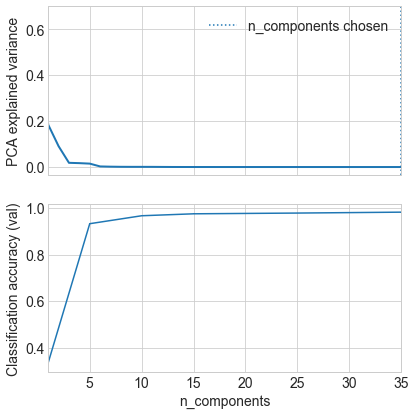

In [66]:
# Plot the PCA spectrum
pca = PCA(random_state=102)
pca2 = pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(grid.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=14))

# For each number of components, find the best classifier results
results = pd.DataFrame(grid.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()
fig.savefig("Plots/PCA_RandomForest.png")

## Support Vector Machine Algorithm

In [21]:
start_time = time.time()

# Create pipeline object with standard scaler and SVC estimator
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=7), threshold=0.01)),
                 ('svm_rbf', SVC(kernel='rbf', gamma='auto', C=110, random_state=8))])

param_grid = {}

kFold = StratifiedKFold(n_splits=5, random_state=9)

grid = GridSearchCV(pipe, param_grid=param_grid, cv=kFold, n_jobs=-1,verbose=10)
grid.fit(X_train, y_train)

print('Best CV Training score: {:.4f}%'.format(grid.best_score_ * 100))
print('Best parameters: {}'.format(grid.best_params_), '\n')
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   46.6s remaining:   31.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Best CV Training score: 97.5968%
Best parameters: {} 

--- 87.29191970825195 seconds ---


In [22]:
print('Test score: {:.4f}%'.format(grid.score(X_test, y_test)*100), '\n')

Test score: 98.1340% 



#### Hyperparameter Tuning SVM

'svm_multi__kernel': ['rbf, 'linear', 'poly', 'sigmoid'],
'svm_multi__C': [1, 10, 100, 105, 110, 115],
'svm_multi__gamma': ['auto', 'scale'],
'svm_multi__degree': [1, 2, 3],
'svm_multi_coef0': [0, 1]

**Best hyperparameters** found by GridSearchCV:
kernel = 'rbf', gamma = 'auto', C = 110

In [23]:
y_pred = grid.best_estimator_.predict(X_test)

In [24]:
confm = confusion_matrix(y_test , y_pred)
                         
FP = confm.sum(axis=0) - np.diag(confm)  
FN = confm.sum(axis=1) - np.diag(confm)
TP = np.diag(confm)
TN = confm.sum() - (FP + FN + TP)

# Metrics
Score = (TP+TN)/(TP+FP+FN+TN)
Errorrate = (FP+FN)/(TP+FP+FN+TN)
Specifity = TN/(TN+FP)
Sensivity = TP/(TP+FN)
Precision = TP/(TP+FP)
F1 = ((1+1**2)*TP)/((1+1**2)*TP+FN+FP)

Score = np.around(Score, decimals=4)
Errorrate = np.around(Errorrate, decimals=4)
Specifity = np.around(Specifity, decimals=4)
Sensivity = np.around(Sensivity, decimals=4)
Precision = np.around(Precision, decimals=4)
F1 = np.around(F1, decimals=4)

header = ('0.0','1.0','2.0','3.0','4.0')
Table=[header, Score,Errorrate,Specifity,Sensivity,Precision, F1]
##################################################################

print(65*"#")
print(' ')
print('PERFORMANCE REPORT Support Vector Machine')
print(' ')
print(65*"#")
print(' ')
print(65*"-")
print("METRICS")
print(65*"-")
print('Overall Accuracy score:  {:.2f}%'.format(accuracy_score(y_test , y_pred)*100))
print('Overall Error rate:      {:.2f}%'.format((1-accuracy_score(y_test , y_pred))*100))
print(65*"-")  
print(tabulate(Table, showindex=(['Rating Class','Score','Error-rate','Specifit','Sensivity','Precision','F1 (beta=1)']))) 
print(65*"-")
print("CONFUSION MATRIX")
print(65*"-")
print(confusion_matrix(y_test , y_pred))
print(65*"-")
print("CLASSIFICATION REPORT")
print(65*"-")
print(classification_report(y_test, y_pred))
print(65*"#")

#################################################################
 
PERFORMANCE REPORT Support Vector Machine
 
#################################################################
 
-----------------------------------------------------------------
METRICS
-----------------------------------------------------------------
Overall Accuracy score:  98.13%
Overall Error rate:      1.87%
-----------------------------------------------------------------
------------  ------  ------  ------  ------  ------
Rating Class  0       1       2       3       4
Score         0.9991  0.9941  0.984   0.9873  0.9983
Error-rate    0.0009  0.0059  0.016   0.0127  0.0017
Specifit      0.9993  0.9958  0.9911  0.9919  0.9986
Sensivity     0.9981  0.9871  0.9556  0.9685  0.9972
Precision     0.9972  0.9829  0.9646  0.9671  0.9944
F1 (beta=1)   0.9976  0.985   0.9601  0.9678  0.9958
------------  ------  ------  ------  ------  ------
-----------------------------------------------------------------
CONFUSION MAT

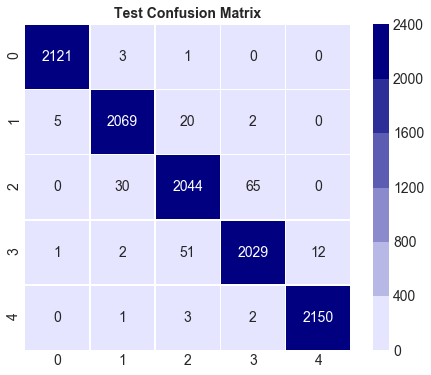

In [25]:
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = [i for i in "01234"], columns = [i for i in "01234"])
plt.figure(figsize= (8,6))
plt.title('Test Confusion Matrix', fontsize=14, weight='bold')
sn.heatmap(df_cm, annot=True, vmin=0, vmax=2400, fmt="d", linewidths=0.4, cmap=sn.light_palette("navy"), square=True)
plt.savefig('Plots/ConfusionMatrixSVM.png')

### Feature Importance

In [35]:
X = df.drop(['tic', 'splticrm','public_date_x', 'mm', 'yyyy','Unnamed: 0', 'Unnamed: 0.1'],1)
feat_labels = X.columns

forest = RandomForestClassifier(n_jobs=-1, random_state=10)
forest.fit(X_train, y_train)

#Feature Selection
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
n = len(X.columns)
for i in range(n):
    print('{0:2d}) {1:7s}  {2:6.4f}'.format(i + 1, feat_labels[indices[i]], importances[indices[i]]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 1) intcov_ratio  0.0386
 2) int_totdebt  0.0384
 3) CAPEI    0.0379
 4) intcov   0.0374
 5) dpr      0.0304
 6) equity_invcap  0.0245
 7) dltt_be  0.0240
 8) lt_debt  0.0216
 9) debt_assets  0.0198
10) int_debt  0.0197
11) PRC      0.0197
12) debt_at  0.0195
13) rect_turn  0.0192
14) GProf    0.0183
15) lt_ppent  0.0182
16) capital_ratio  0.0169
17) pay_turn  0.0168
18) cash_lt  0.0167
19) cash_conversion  0.0166
20) cash_debt  0.0163
21) gpm      0.0158
22) ps       0.0155
23) at_turn  0.0152
24) aftret_equity  0.0145
25) ptpm     0.0142
26) inv_turn  0.0141
27) cfm      0.0140
28) debt_invcap  0.0135
29) debt_ebitda  0.0135
30) pretret_earnat  0.0129
31) totdebt_invcap  0.0128
32) sale_invcap  0.0123
33) fcf_ocf  0.0122
34) curr_ratio  0.0121
35) invt_act  0.0119
36) curr_debt  0.0118
37) DIVYIELD  0.0117
38) debt_capital  0.0117
39) opmbd    0.0116
40) cash_ratio  0.0116
41) profit_lct  0.0116
42) efftax   0.0115
43) rect_act  0.0112
44) aftret_invcapx  0.0106
45) npm      0.0103
4

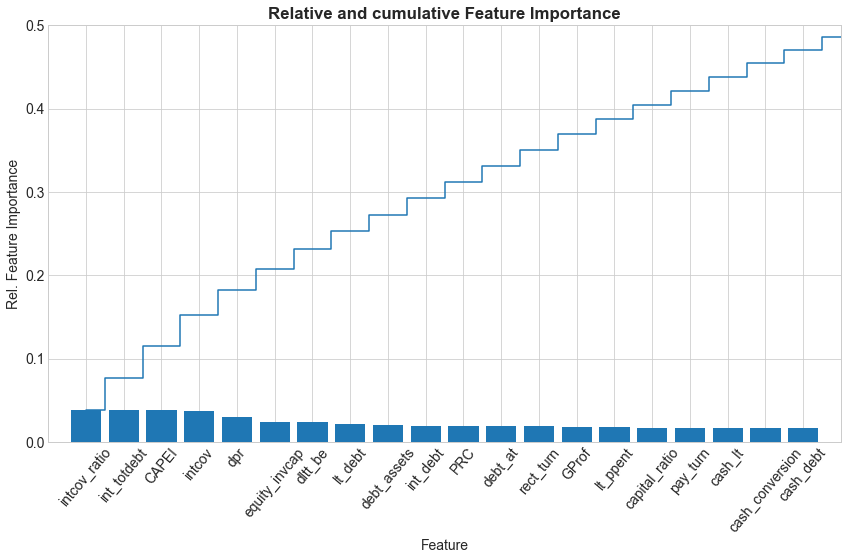

In [37]:
#Plot Feature Importance
feat_imp = np.sort(importances)[::-1]
sum_feat_imp = np.cumsum(feat_imp)[:n]

plt.figure(figsize=(12, 8))
plt.title("Relative and cumulative Feature Importance", weight='bold')
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), feat_labels[indices[:20]], rotation=50)
plt.xlim([-1, 20])
plt.ylim(0, 0.5)
plt.xlabel('Feature')
plt.ylabel('Rel. Feature Importance')
plt.step(range(n), sum_feat_imp, where='mid', 
         label='Cumulative importance')
plt.tight_layout();
plt.savefig("Plots/FeartureImportance.png")

In [ ]:
playsound('soundeffect.wav')